In [154]:
import pandas as pd 
import json
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import urllib.request
%matplotlib inline
import re
import geopy
from geopy.geocoders import Nominatim
from itertools import combinations, takewhile
import collections
from simhash import Simhash, SimhashIndex
import matplotlib.dates as mdates
import numpy as np

pd.set_option('max_colwidth',140)

### Read json file created from RCC cluster using spark
### This json has tweets from Uhicago, Stanford , yale and purdue university

In [155]:
import json    
data = []
with open('/Users/ashish/Big_Data/final_proj/element12.json') as f:
    for line in f:
        data.append(json.loads(line))

#### "element" pandas dataframe will hold required Data columns for further analysis

In [156]:
element= pd.DataFrame(data)
element['screen_name'].count()

1244224

####  Frequncy of tweetns by University

In [157]:
elementByUniv= element[['SourceID','NameofUniv']].groupby('NameofUniv').agg(['count'])
elementByUniv.columns = ['TweetCount']
elementByUniv['NameofUniv'] = elementByUniv.index
elementByUniv.reset_index(inplace=True, drop=True)
elementByUniv

,TweetCount,NameofUniv
0,96445,Other
1,141771,purdue
2,570043,stanford
3,133996,uchicago
4,301969,yale


#### Listing all data columns created for data analysis

In [186]:
list(element)

['Day',
 'EXhashtagT',
 'Month',
 'NameofUniv',
 'QuotedID',
 'RetweetSourceID',
 'SourceID',
 'TweetDate',
 'Uchicago_Binary',
 'Year',
 'coordinates1',
 'coordinates2',
 'coordinates3',
 'country',
 'countryCode',
 'created_at',
 'followers_count',
 'full_text',
 'hashtagT',
 'lang',
 'placeName',
 'place_type',
 'purdue_Binary',
 'retweet_count',
 'retweeted',
 'screen_name',
 'stanford_Binary',
 'text',
 'timestamp_ms',
 'university_tweet',
 'user_location',
 'verified',
 'yale_Binary',
 'TweetCnt',
 'RTCnt',
 'OtherTopics']

#### Flag Orignal Tweet in one column
#### Flag Univeristy Tweet in one column

In [187]:
element['TweetCnt'] =  element['text'].apply(lambda x: 0 if "RT @" in x else 1)
element['RTCnt'] =  element['text'].apply(lambda x: 1 if "RT @" in x else 0)
element['university_tweet'] =  element['text'].apply(lambda x: 1 if ("RT @" not in x) &('universi' in x) else 0)
element['OtherTopics'] =  element['text'].apply(lambda x: 1 if ("RT @" not in x) &('universi' not in x) else 0)

In [188]:
element[['TweetCnt','text','RTCnt']].head(5)

,TweetCnt,text,RTCnt
0,1,"""This is going to save us SOOO much money!"" - Stanford University #stopdrymarkeritis https://t.co/Y6p5b9pI4M",0
1,0,RT @merelynora: Angela Bassett receives her third degree from Yale University today. Powerful. https://t.co/UlHHku02xp,1
2,0,RT @merelynora: Angela Bassett receives her third degree from Yale University today. Powerful. https://t.co/UlHHku02xp,1
3,0,RT @merelynora: Angela Bassett receives her third degree from Yale University today. Powerful. https://t.co/UlHHku02xp,1
4,0,RT @merelynora: Angela Bassett receives her third degree from Yale University today. Powerful. https://t.co/UlHHku02xp,1


In [189]:
element.loc[element['TweetCnt'] ==0 ,['text','university_tweet']].head()

,text,university_tweet
1,RT @merelynora: Angela Bassett receives her third degree from Yale University today. Powerful. https://t.co/UlHHku02xp,0
2,RT @merelynora: Angela Bassett receives her third degree from Yale University today. Powerful. https://t.co/UlHHku02xp,0
3,RT @merelynora: Angela Bassett receives her third degree from Yale University today. Powerful. https://t.co/UlHHku02xp,0
4,RT @merelynora: Angela Bassett receives her third degree from Yale University today. Powerful. https://t.co/UlHHku02xp,0
5,RT @aVeryRichBish: Both Angela Bassett and Kimora Lee Simmons received degrees today from Yale University and Hartford University. 🔥 htt...,0


In [190]:
element.loc[element['TweetCnt'] ==1 ,['text']].head()

,text
0,"""This is going to save us SOOO much money!"" - Stanford University #stopdrymarkeritis https://t.co/Y6p5b9pI4M"
74,"If this dude ends up with Jeff Brown, watch out for Purdue https://t.co/YWhxZK2Ny8"
188,"If this dude ends up with Jeff Brohm, watch out for Purdue https://t.co/YWhxZK2Ny8"
501,Why do so many older people limp? - UChicago Medicine https://t.co/GCz4W1TUXK
544,So...someone not involved with the university whatsoever is bringing this lawsuit. *checks Yale diploma on the wall… https://t.co/1uG4lz...


In [191]:
element.loc[element['university_tweet'] ==1 ,['text']].head()

,text
544,So...someone not involved with the university whatsoever is bringing this lawsuit. *checks Yale diploma on the wall… https://t.co/1uG4lz...
1055,"Me freshman year : ""I'm going to go to Stanford university once high school ends""\nMe sophmore year: ""I'm going to g… https://t.co/zncDo..."
1342,@Stanford so is #bbqbecky an employee of Stanford university or not? On her deleted social media page it said emplo… https://t.co/rRF8zN...
3346,"Good. In line w this, Yale and other universities should also take better action to protect its students from sexua… https://t.co/wT8NyG..."
4496,wait since when is Yale a conservative university?


#### Show Influential profiles by number of original tweets posted 

In [192]:
elementCountbyprofile= element.groupby(['NameofUniv','SourceID','screen_name'],as_index=False).agg({'retweet_count':'sum', 'university_tweet': 'sum',\
'TweetCnt':'sum','RTCnt':'sum'}).rename(columns={'retweet_count':'retweetTotal','university_tweet':'UnivTweetTotal',"TweetCnt":'TweetCount',\
                                                 'RTCnt':'RTCntTotal'}).sort_values(['TweetCount'], ascending=False)
elementCountbyprofile[['screen_name','NameofUniv','TweetCount','retweetTotal','UnivTweetTotal','RTCntTotal']].head(10)

,screen_name,NameofUniv,TweetCount,retweetTotal,UnivTweetTotal,RTCntTotal
450735,CMasden7,stanford,4916,6.0,183,13
412546,stickerladysv,stanford,4420,64.0,0,1
252591,StanfordSpyder,stanford,3338,0.0,0,0
759963,CMasden7,yale,1432,0.0,56,1
184054,startupcrunch,stanford,1131,0.0,5,0
359195,haileysecretary,stanford,1080,0.0,0,37
497086,ChicagoMaroons,uchicago,995,72.0,0,161
347876,sofiaorden,stanford,961,0.0,0,0
379312,kellyb00n,stanford,953,0.0,0,11
508502,UChicago,uchicago,915,933.0,7,468


#### Show Influential profiles by number of Re-tweets they received 

In [193]:
elementCountbyprofile2= element.groupby(['NameofUniv','SourceID','screen_name'],as_index=False).agg({'retweet_count':'sum', 'university_tweet': 'sum',\
'TweetCnt':'sum','RTCnt':'sum'}).rename(columns={'retweet_count':'retweetTotal','university_tweet':'UnivTweetTotal',"TweetCnt":'TweetCount',\
                                                 'RTCnt':'RTCntTotal'}).sort_values(['retweetTotal'], ascending=False)
elementCountbyprofile2[['screen_name','NameofUniv','retweetTotal','TweetCount','UnivTweetTotal','RTCntTotal']].head(10)

,screen_name,NameofUniv,retweetTotal,TweetCount,UnivTweetTotal,RTCntTotal
531200,RaineyRave,uchicago,319393.0,7,0,69
530082,itzelnvelazquez,uchicago,248320.0,51,0,110
178741,stevenefowler,stanford,225664.0,0,0,2
445141,NathanH08568227,stanford,178611.0,0,0,1
215553,COAGBFashion,stanford,172603.0,0,0,14
532688,rileyiosborn,uchicago,171698.0,0,0,2
533081,_m3lk_,uchicago,171583.0,0,0,2
724776,itskatomall,yale,163840.0,0,0,1
337122,AshlynMartin14,stanford,162252.0,0,0,1
752331,STAYWILD4EVE,yale,158250.0,60,0,59


In [194]:
elementCountbyprofile3= element.groupby(['NameofUniv','SourceID','screen_name'],as_index=False).agg({'retweet_count':'sum', 'university_tweet': 'sum',\
'TweetCnt':'sum','RTCnt':'sum'}).rename(columns={'retweet_count':'retweetTotal','university_tweet':'UnivTweetTotal',"TweetCnt":'TweetCount',\
                                                 'RTCnt':'RTCntTotal'}).sort_values(['RTCntTotal'], ascending=False)

elementCountbyprofile3.head(10)

,NameofUniv,SourceID,screen_name,retweetTotal,UnivTweetTotal,TweetCount,RTCntTotal
453678,stanford,887182298340245504,hamiltonsmith18,5984.0,0,0,1562
519656,uchicago,417357386,uchicagogsu,39221.0,13,486,1076
376384,stanford,2972101060,n8taki,0.0,0,0,887
361821,stanford,2601375710,wendchain,0.0,0,0,886
379206,stanford,3033747106,a2yulia,0.0,0,0,828
379309,stanford,3035768507,in3ez,0.0,0,0,801
508526,uchicago,131644003,LyoLouisJacques,2260.0,0,35,708
697857,yale,2821421079,honischgalerie,0.0,0,419,691
697858,yale,2821421079,kinibottommintd,0.0,0,128,530
379313,stanford,3035799467,h011x,0.0,0,0,516


### Flag tweet as "othertopics" if it does not contain "University" or "universities" words 

In [195]:
elementCountbyprofile['OtherTopics'] = elementCountbyprofile['TweetCount'] -elementCountbyprofile['UnivTweetTotal']
#elementCountbyprofile = elementCountbyprofile.sort_values(['OtherTopics'], ascending=False)#.head(50)
#elementCountbyprofile.head(10)

,screen_name,NameofUniv,TweetCount,RTCntTotal
0,ChicagoMaroons,uchicago,995,161
1,UChicago,uchicago,915,468
2,uchicagogsu,uchicago,486,1076
3,DanW_BCI,uchicago,406,0
4,UChicagoArts,uchicago,200,77
5,shazrasul,uchicago,197,104
6,ViewChicago,uchicago,182,217
7,mihalyfy,uchicago,181,11
8,pstanpolitics,uchicago,173,55
9,HarrisPolicy,uchicago,134,122


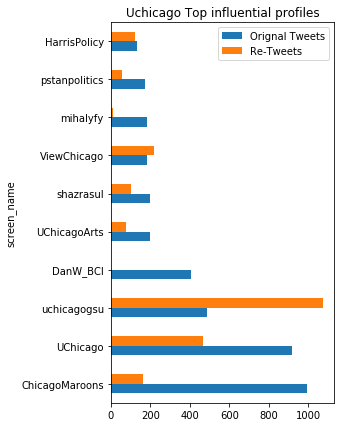

In [196]:
import seaborn
uchicago_infl =  elementCountbyprofile.loc[elementCountbyprofile['NameofUniv']=='uchicago',\
                                           ['screen_name','NameofUniv','TweetCount','RTCntTotal']].head(10)
uchicago_infl.reset_index(inplace=True, drop=True)
uchicago_infl.plot(x="screen_name", y=["TweetCount", "RTCntTotal"], kind="barh",figsize = (4,7),\
                   title='Uchicago Top influential profiles')
plt.legend(['Orignal Tweets', 'Re-Tweets'],loc = 'best')
uchicago_infl

,screen_name,NameofUniv,TweetCount,RTCntTotal
0,CMasden7,stanford,4916,13
1,stickerladysv,stanford,4420,1
2,StanfordSpyder,stanford,3338,0
3,startupcrunch,stanford,1131,0
4,haileysecretary,stanford,1080,37
5,sofiaorden,stanford,961,0
6,kellyb00n,stanford,953,11
7,holidayhqteam,stanford,807,0
8,thefreshmarker,stanford,798,0
9,truthsearch1957,stanford,754,196


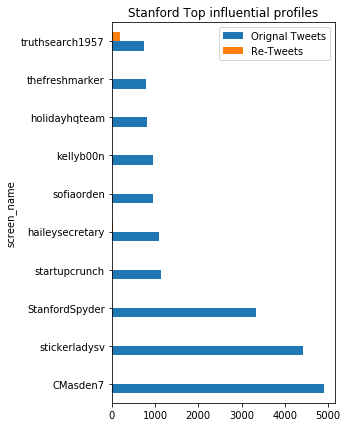

In [197]:
stanford_infl =  elementCountbyprofile.loc[elementCountbyprofile['NameofUniv']=='stanford',\
                                           ['screen_name','NameofUniv','TweetCount','RTCntTotal']].head(10)
stanford_infl.reset_index(inplace=True, drop=True)
stanford_infl.plot(x="screen_name", y=["TweetCount", "RTCntTotal"], kind="barh",figsize = (4,7),\
                   title='Stanford Top influential profiles')
plt.legend(['Orignal Tweets', 'Re-Tweets'],loc = 'best')
stanford_infl

,screen_name,NameofUniv,TweetCount,RTCntTotal
0,nbairdjc,purdue,252,49
1,GoldandBlackcom,purdue,245,90
2,BeeBestDeals,purdue,222,0
3,DealCascade,purdue,215,0
4,deal_guys,purdue,186,0
5,Hottest_Online,purdue,183,0
6,Guys_Deal,purdue,183,0
7,up_deals,purdue,180,0
8,SparkleDealer,purdue,178,0
9,DialDeals,purdue,176,0


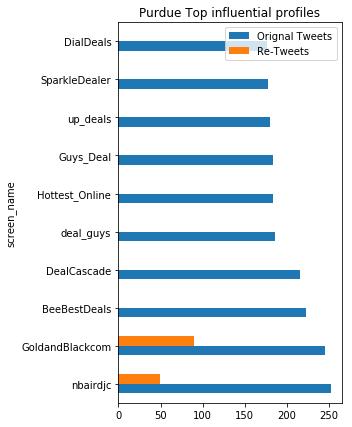

In [198]:

purdue_infl =  elementCountbyprofile.loc[elementCountbyprofile['NameofUniv']=='purdue',\
                                           ['screen_name','NameofUniv','TweetCount','RTCntTotal']].head(10)
purdue_infl.reset_index(inplace=True, drop=True)
purdue_infl.plot(x="screen_name", y=["TweetCount", "RTCntTotal"], kind="barh",figsize = (4,7),\
                   title='Purdue Top influential profiles')
plt.legend(['Orignal Tweets', 'Re-Tweets'],loc = 'best')
purdue_infl

,screen_name,NameofUniv,TweetCount,RTCntTotal
0,CMasden7,yale,1432,1
1,Chi_Red_Dragon,yale,742,0
2,honischgalerie,yale,419,691
3,EllisWashington,yale,379,0
4,jurnskeff,yale,371,239
5,haileysecretary,yale,273,13
6,sofiaorden,yale,257,0
7,Finance_graduat,yale,248,0
8,suishiiazuma,yale,202,0
9,iwaminebot,yale,178,0


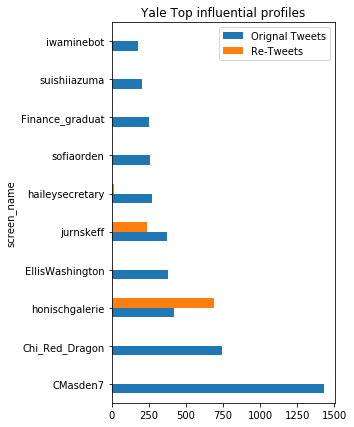

In [199]:
yale_infl =  elementCountbyprofile.loc[elementCountbyprofile['NameofUniv']=='yale',\
                                           ['screen_name','NameofUniv','TweetCount','RTCntTotal']].head(10)
yale_infl.reset_index(inplace=True, drop=True)
yale_infl.plot(x="screen_name", y=["TweetCount", "RTCntTotal"], kind="barh",figsize = (4,7),\
                   title='Yale Top influential profiles')
plt.legend(['Orignal Tweets', 'Re-Tweets'],loc = 'best')
yale_infl

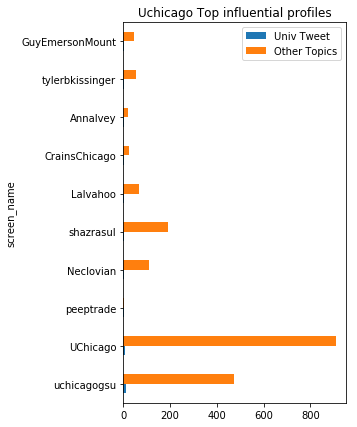

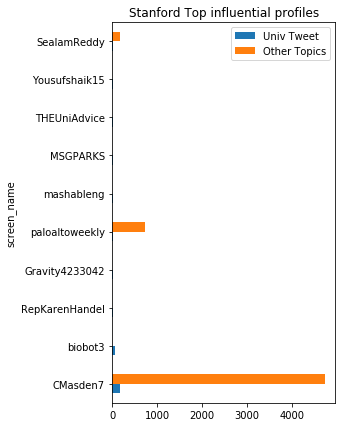

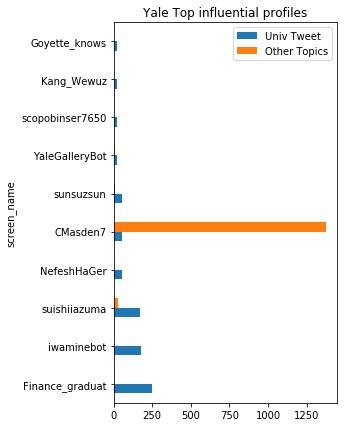

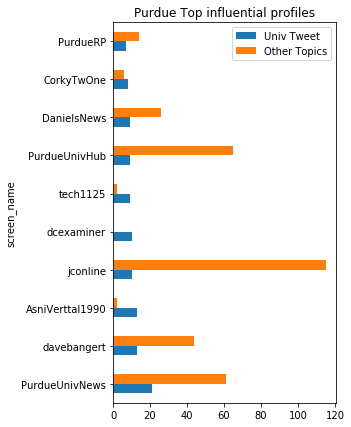

In [200]:
uchicago_infl2 =  elementCountbyprofile.loc[elementCountbyprofile['NameofUniv']=='uchicago',\
                                           ['screen_name','NameofUniv','UnivTweetTotal','OtherTopics']].\
                    sort_values(['UnivTweetTotal'], ascending=False).head(10)
uchicago_infl2.reset_index(inplace=True, drop=True)
uchicago_infl2.plot(x="screen_name", y=["UnivTweetTotal", "OtherTopics"], kind="barh",figsize = (4,7),\
                   title='Uchicago Top influential profiles')
plt.legend(['Univ Tweet', 'Other Topics'],loc = 'best')


stanford_infl2 =  elementCountbyprofile.loc[elementCountbyprofile['NameofUniv']=='stanford',\
                                           ['screen_name','NameofUniv','UnivTweetTotal','OtherTopics']].\
                    sort_values(['UnivTweetTotal'], ascending=False).head(10)
stanford_infl2.reset_index(inplace=True, drop=True)
stanford_infl2.plot(x="screen_name", y=["UnivTweetTotal", "OtherTopics"], kind="barh",figsize = (4,7),\
                   title='Stanford Top influential profiles')
plt.legend(['Univ Tweet', 'Other Topics'],loc = 'best')

yale_infl2 =  elementCountbyprofile.loc[elementCountbyprofile['NameofUniv']=='yale',\
                                           ['screen_name','NameofUniv','UnivTweetTotal','OtherTopics']].\
                    sort_values(['UnivTweetTotal'], ascending=False).head(10)
yale_infl2.reset_index(inplace=True, drop=True)
yale_infl2.plot(x="screen_name", y=["UnivTweetTotal", "OtherTopics"], kind="barh",figsize = (4,7),\
                   title='Yale Top influential profiles')
plt.legend(['Univ Tweet', 'Other Topics'],loc = 'best')


purdue_infl2 =  elementCountbyprofile.loc[elementCountbyprofile['NameofUniv']=='purdue',\
                                           ['screen_name','NameofUniv','UnivTweetTotal','OtherTopics']].\
                    sort_values(['UnivTweetTotal'], ascending=False).head(10)
purdue_infl2.reset_index(inplace=True, drop=True)
purdue_infl2.plot(x="screen_name", y=["UnivTweetTotal", "OtherTopics"], kind="barh",figsize = (4,7),\
                   title='Purdue Top influential profiles')
plt.legend(['Univ Tweet', 'Other Topics'],loc = 'best')

#### Summaries Tweet count by location of Author and create separate dataframe for each university 

In [201]:

element_location= element.groupby(['NameofUniv','user_location'],as_index=False).agg({'TweetCnt':'count'}).\
rename(columns={"TweetCnt":'TweetCount'}).sort_values(['TweetCount'], ascending=False).head(30)

element_location.reset_index(inplace=True, drop=True)
purdue_df = element_location.loc[(element_location['NameofUniv'] == 'purdue') & \
                                 (element_location['user_location'].str.contains(',',regex=False)),:].head(5)

purdue_df[['city','state']] = purdue_df['user_location'].str.split(pat=',',expand=True)
purdue_df.reset_index(inplace=True, drop=True)

stanford_df = element_location.loc[(element_location['NameofUniv'] == 'stanford') & \
                                 (element_location['user_location'].str.contains(',',regex=False)),:].head(5)
stanford_df[['city','state']] = stanford_df['user_location'].str.split(pat=',',expand=True)
stanford_df.reset_index(inplace=True, drop=True)

uchicago_df = element_location.loc[(element_location['NameofUniv'] == 'uchicago') & \
                                 (element_location['user_location'].str.contains(',',regex=False)),:].head(5)
uchicago_df[['city','state']] = uchicago_df['user_location'].str.split(pat=',',expand=True)
uchicago_df.reset_index(inplace=True, drop=True)

yale_df = element_location.loc[(element_location['NameofUniv'] == 'yale') & \
                                 (element_location['user_location'].str.contains(',',regex=False)),:].head(5)
yale_df[['city','state']] = yale_df['user_location'].str.split(pat=',',expand=True)
yale_df.reset_index(inplace=True, drop=True)

uchicago_df.head(10)


,NameofUniv,user_location,TweetCount,city,state
0,uchicago,"Chicago, IL",17273,Chicago,IL
1,uchicago,"Chicago, Illinois",3796,Chicago,Illinois
2,uchicago,"Chicago, IL 60637",1696,Chicago,IL 60637


In [202]:
purdue_df[['NameofUniv','user_location','TweetCount']].head(10)

,NameofUniv,user_location,TweetCount
0,purdue,"West Lafayette, IN",4984
1,purdue,"Indianapolis, IN",1900


In [203]:
stanford_df[['NameofUniv','user_location','TweetCount']].head(10)

,NameofUniv,user_location,TweetCount
0,stanford,"Stanford, CA",6823
1,stanford,"San Francisco, CA",5252
2,stanford,"California, USA",4913
3,stanford,"Palo Alto, CA",4176
4,stanford,"USA - PALO ALTO, CALIFORNIA",4118


In [204]:
yale_df[['NameofUniv','user_location','TweetCount']].head(10)

,NameofUniv,user_location,TweetCount
0,yale,"New Haven, CT",2017
1,yale,"California, USA",1983
2,yale,"Chicago, IL",1903


### Plot Tweet counts by author's location

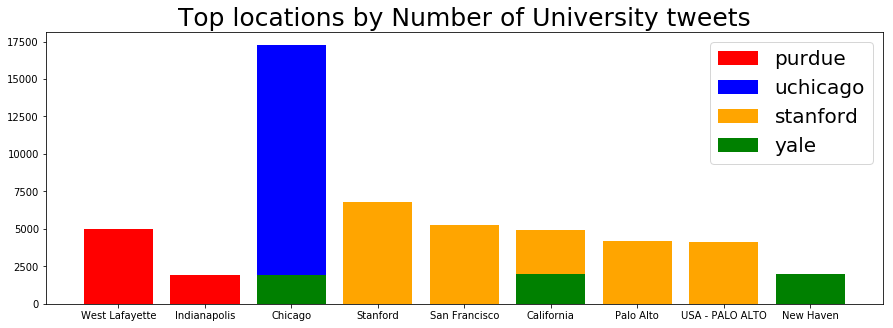

In [205]:
#element_location.plot.bar(x = 'user_location', y = 'TweetCount', rot = 40)
plt.figure(figsize = (15, 5))
plt.bar(purdue_df['city'], purdue_df['TweetCount'], color = 'red')
plt.bar(uchicago_df['city'], uchicago_df['TweetCount'], color = 'blue')
plt.bar(stanford_df['city'], stanford_df['TweetCount'], color = 'orange')
plt.bar(yale_df['city'], yale_df['TweetCount'], color = 'green')

plt.title('Top locations by Number of University tweets', fontdict = {'fontsize':25})
plt.legend(['purdue', 'uchicago','stanford','yale'],loc = 'best', prop = {'size': 20})

### Add Latitude and Longitude from Authors Location columns , use geopy package api for this 

In [206]:
def Latlat(user_location):
    geolocator = Nominatim(user_agent="Ashish",timeout=3)
    location = geolocator.geocode(user_location)
    lat = location.latitude
    longi = location.longitude
    return lat,longi



In [207]:

element_location2= element.groupby(['NameofUniv','user_location'],as_index=False).agg({'TweetCnt':'count'}).\
rename(columns={"TweetCnt":'TweetCount'}).sort_values(['TweetCount'], ascending=False).head(50)
element_location2['TweetCount'] = element_location2['TweetCount'].astype(int)
element_location2.reset_index(inplace=True, drop=True)

for i, row in element_location2.iterrows():
    element_location2.loc[i,'latitude'],element_location2.loc[i,'longitude'] = Latlat(element_location2.loc[i,'user_location'])

for i, row in element_location2.iterrows():
    element_location2.loc[i,'UnivLat'],element_location2.loc[i,'Univlongi'] = Latlat(element_location2.loc[i,'user_location'])

stanford_df2 = element_location2.loc[(element_location2['NameofUniv'] == 'stanford'),:]
purdue_df2 = element_location2.loc[(element_location2['NameofUniv'] == 'purdue'),:]
uchicago_df2 = element_location2.loc[(element_location2['NameofUniv'] == 'uchicago'),:]
yale_df2 = element_location2.loc[(element_location2['NameofUniv'] == 'yale'),:]


In [208]:
uchicago_df2.head(10)

,NameofUniv,user_location,TweetCount,latitude,longitude,UnivLat,Univlongi
0,uchicago,"Chicago, IL",17273,41.875562,-87.624421,41.875562,-87.624421
3,uchicago,Chicago,6216,41.875562,-87.624421,41.875562,-87.624421
13,uchicago,"Chicago, Illinois",3796,41.875562,-87.624421,41.875562,-87.624421
29,uchicago,"Chicago, IL 60637",1696,41.875562,-87.624421,41.875562,-87.624421
34,uchicago,United States,1630,39.783730,-100.445882,39.783730,-100.445882
36,uchicago,"Washington, DC",1603,38.895009,-77.036563,38.895009,-77.036563


In [209]:
purdue_df2.head()

,NameofUniv,user_location,TweetCount,latitude,longitude,UnivLat,Univlongi
7,purdue,"West Lafayette, IN",4984,40.425869,-86.908066,40.425869,-86.908066
19,purdue,United States,2020,39.783730,-100.445882,39.783730,-100.445882
25,purdue,"Indianapolis, IN",1900,39.768333,-86.158350,39.768333,-86.158350
40,purdue,"Indiana, USA",1533,40.327013,-86.174693,40.327013,-86.174693
45,purdue,"Chicago, IL",1404,41.875562,-87.624421,41.875562,-87.624421


### plot top 50 authors location on USA map (by tweet counts)

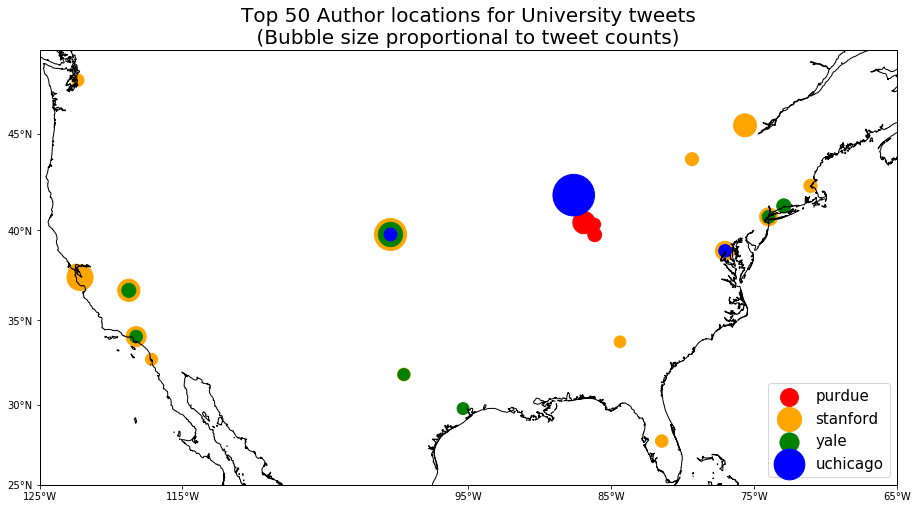

<Figure size 432x288 with 0 Axes>

In [210]:
import cartopy.crs as ccrs
import math as log
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
plt.figure(figsize=(18,8))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines('10m')

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)

ax.set_yticks([20,25,30,35,40,45,50], crs=ccrs.PlateCarree())
ax.set_xticks([-125, -115, -95, -85,-75,-65,-50], crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_extent([-125, -65, 25, 45])
purdue2= plt.scatter(purdue_df2['longitude'],purdue_df2['latitude'],
                    color='red', s=purdue_df2['TweetCount']/10, transform=ccrs.PlateCarree())
stanford2= plt.scatter(stanford_df2['longitude'],stanford_df2['latitude'],
                    color='orange',s=stanford_df2['TweetCount']/10, transform=ccrs.PlateCarree())
yale2= plt.scatter(yale_df2['longitude'],yale_df2['latitude'],
                    color='green', s=yale_df2['TweetCount']/10, transform=ccrs.PlateCarree())
uchicago2= plt.scatter(uchicago_df2['longitude'],uchicago_df2['latitude'],
                    color='blue',  s=uchicago_df2['TweetCount']/10,transform=ccrs.PlateCarree())
plt.title('Top 50 Author locations for University tweets\n (Bubble size proportional to tweet counts) ', fontdict = {'fontsize':20})
plt.legend((purdue2,stanford2,yale2,uchicago2),('purdue','stanford','yale','uchicago'),\
           loc = 'lower right', prop = {'size': 15})
plt.show()
plt.savefig("standord.png")

## Plot Tweets Time line for all university 

In [211]:
element_date= element.groupby(['TweetDate','NameofUniv'],as_index=False).agg({'TweetCnt':'count'}).\
rename(columns={"TweetCnt":'TweetCount'})
element_date.reset_index(inplace=True, drop=True)
element_date['TweetDate'] = pd.to_datetime(element_date['TweetDate'])
element_date.head()

,TweetDate,NameofUniv,TweetCount
0,2017-06-22,Other,40
1,2017-06-22,purdue,54
2,2017-06-22,stanford,755
3,2017-06-22,uchicago,128
4,2017-06-22,yale,162


In [212]:
print(element_date.count())
element_date.head()
element_date_pivot= element_date.pivot(index='TweetDate', columns='NameofUniv', values='TweetCount')
element_date_pivot.head()

TweetDate     2358
NameofUniv    2358
TweetCount    2358
dtype: int64


NameofUniv,Other,purdue,stanford,uchicago,yale
TweetDate,,,,,
2017-06-22,40.0,54.0,755.0,128.0,162.0
2017-06-23,80.0,102.0,904.0,128.0,221.0
2017-06-24,62.0,134.0,814.0,83.0,332.0
2017-06-25,156.0,101.0,796.0,89.0,351.0
2017-06-26,129.0,131.0,1090.0,112.0,194.0


In [213]:

purdue_df = element_date_pivot.loc[:,['purdue']]
purdue_df['TweetDate']=purdue_df.index
purdue_df.reset_index(inplace=True, drop=True)

stanford_df = element_date_pivot.loc[:,['stanford']]
stanford_df['TweetDate']=stanford_df.index
stanford_df.reset_index(inplace=True, drop=True)

uchicago_df = element_date_pivot.loc[:,['uchicago']]
uchicago_df['TweetDate']=uchicago_df.index
uchicago_df.reset_index(inplace=True, drop=True)

yale_df = element_date_pivot.loc[:,['yale']]
yale_df['TweetDate']=yale_df.index
yale_df.reset_index(inplace=True, drop=True)


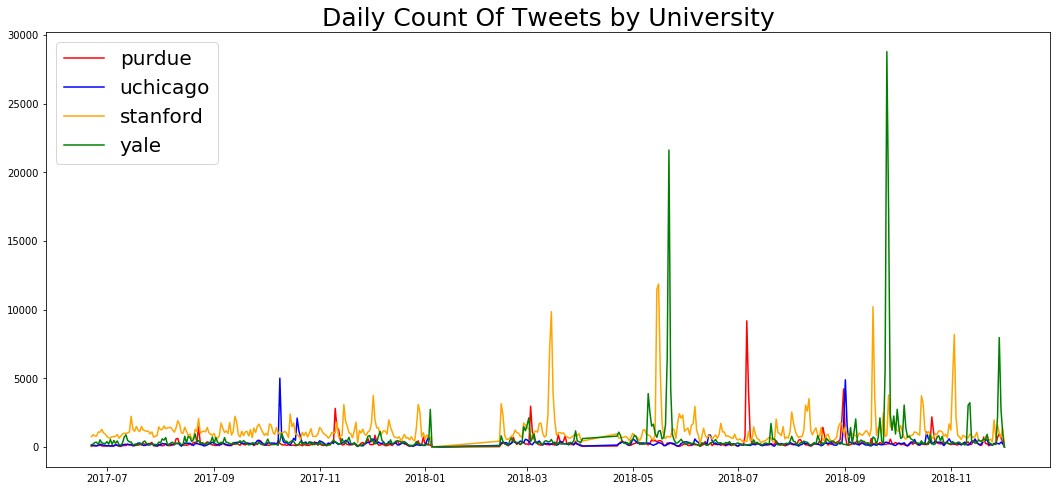

In [214]:
plt.figure(figsize = (18, 8))
plt.plot(purdue_df['TweetDate'], purdue_df['purdue'], color = 'red')
plt.plot(uchicago_df['TweetDate'], uchicago_df['uchicago'],color = 'blue')
plt.plot(stanford_df['TweetDate'], stanford_df['stanford'],color = 'orange')
plt.plot(yale_df['TweetDate'], yale_df['yale'],color = 'green')

plt.title('Daily Count Of Tweets by University', fontdict = {'fontsize':25})
plt.legend(['purdue', 'uchicago','stanford','yale'],loc = 'best', prop = {'size': 20})

In [215]:
purdue_df['TweetDate'].head()

0   2017-06-22
1   2017-06-23
2   2017-06-24
3   2017-06-25
4   2017-06-26
Name: TweetDate, dtype: datetime64[ns]

In [216]:
elementCountbyprofile.loc[elementCountbyprofile['NameofUniv'] == 'stanford',:].head(10)

,NameofUniv,SourceID,screen_name,retweetTotal,UnivTweetTotal,TweetCount,RTCntTotal,OtherTopics
450735,stanford,880005795974217728,CMasden7,6.0,183,4916,13,4733
412546,stanford,730577022120919041,stickerladysv,64.0,0,4420,1,4420
252591,stanford,258114278,StanfordSpyder,0.0,0,3338,0,3338
184054,stanford,25382122,startupcrunch,0.0,5,1131,0,1126
359195,stanford,2533835623,haileysecretary,0.0,0,1080,37,1080
347876,stanford,2287659854,sofiaorden,0.0,0,961,0,961
379312,stanford,3035786139,kellyb00n,0.0,0,953,11,953
334313,stanford,1607173465,holidayhqteam,0.0,0,807,0,807
403222,stanford,4764165973,thefreshmarker,0.0,0,798,0,798
367850,stanford,2790314135,truthsearch1957,429.0,0,754,196,754


In [217]:
elementCountbyprofile.loc[elementCountbyprofile['NameofUniv'] == 'purdue',:].head(10)

,NameofUniv,SourceID,screen_name,retweetTotal,UnivTweetTotal,TweetCount,RTCntTotal,OtherTopics
80915,purdue,66879211,nbairdjc,57.0,1,252,49,251
75825,purdue,31171069,GoldandBlackcom,91.0,0,245,90,245
149841,purdue,822934480209973251,BeeBestDeals,0.0,0,222,0,222
147850,purdue,791806496480825345,DealCascade,0.0,1,215,0,214
147849,purdue,791805594537693185,deal_guys,0.0,3,186,0,183
147880,purdue,792500939148099588,Hottest_Online,0.0,5,183,0,178
150167,purdue,826590275963334656,Guys_Deal,0.0,2,183,0,181
149842,purdue,822937948073168896,up_deals,0.0,2,180,0,178
149521,purdue,819367570218303489,SparkleDealer,0.0,3,178,0,175
149562,purdue,819738982762381312,DialDeals,0.0,2,176,0,174


In [218]:
elementCountbyprofile.loc[elementCountbyprofile['NameofUniv'] == 'yale',:].head(10)

,NameofUniv,SourceID,screen_name,retweetTotal,UnivTweetTotal,TweetCount,RTCntTotal,OtherTopics
759963,yale,880005795974217728,CMasden7,0.0,56,1432,1,1376
654592,yale,952726698,Chi_Red_Dragon,0.0,0,742,0,742
697857,yale,2821421079,honischgalerie,0.0,0,419,691,419
579345,yale,50617408,EllisWashington,0.0,0,379,0,379
651535,yale,859728522,jurnskeff,0.0,0,371,239,371
689631,yale,2533835623,haileysecretary,0.0,0,273,13,273
680801,yale,2287659854,sofiaorden,0.0,0,257,0,257
726797,yale,4877949423,Finance_graduat,0.0,248,248,0,0
594383,yale,136882449,suishiiazuma,0.0,174,202,0,28
681211,yale,2298064916,iwaminebot,0.0,178,178,0,0


In [219]:
elementCountbyprofile.loc[elementCountbyprofile['NameofUniv'] == 'uchicago',:].head(10)

,NameofUniv,SourceID,screen_name,retweetTotal,UnivTweetTotal,TweetCount,RTCntTotal,OtherTopics
497086,uchicago,20270494,ChicagoMaroons,72.0,0,995,161,995
508502,uchicago,131144285,UChicago,933.0,7,915,468,908
519656,uchicago,417357386,uchicagogsu,39221.0,13,486,1076,473
548425,uchicago,790683208111181825,DanW_BCI,0.0,0,406,0,406
505874,uchicago,87277959,UChicagoArts,10.0,1,200,77,199
492547,uchicago,1356241,shazrasul,897.0,4,197,104,193
518083,uchicago,367180223,ViewChicago,64.0,0,182,217,182
499473,uchicago,28641512,mihalyfy,9.0,2,181,11,179
539665,uchicago,3033693676,pstanpolitics,58.0,1,173,55,172
513458,uchicago,248941406,HarrisPolicy,72.0,3,134,122,131


In [220]:
#element.loc[:5,['text']]
words = ' '.join(element.loc[0:10,'text'])
words

'"This is going to save us SOOO much money!" - Stanford University  #stopdrymarkeritis  https://t.co/Y6p5b9pI4M RT @merelynora: Angela Bassett receives her third degree from Yale University today. Powerful. https://t.co/UlHHku02xp RT @merelynora: Angela Bassett receives her third degree from Yale University today. Powerful. https://t.co/UlHHku02xp RT @merelynora: Angela Bassett receives her third degree from Yale University today. Powerful. https://t.co/UlHHku02xp RT @merelynora: Angela Bassett receives her third degree from Yale University today. Powerful. https://t.co/UlHHku02xp RT @aVeryRichBish: Both Angela Bassett and Kimora Lee Simmons received degrees today from Yale University and Hartford University. 🔥 https:… RT @merelynora: Angela Bassett receives her third degree from Yale University today. Powerful. https://t.co/UlHHku02xp RT @merelynora: Angela Bassett receives her third degree from Yale University today. Powerful. https://t.co/UlHHku02xp RT @John_KissMyBot: Hillary Is St

In [221]:
import matplotlib.pyplot as plt
#import nltk as nltk
from wordcloud import WordCloud, STOPWORDS
#from nltk.corpus import stopwords

def plotWordCloud(words):
    
#    s=set(stopwords.words('english'))
#    s.add('university')
#    s.add('uchicago')
#    s.add('purdue')
#    s.add('stanford')
#    s.add('yale')

    stopwords = set(STOPWORDS)
    stopwords.add('university')    
    stopwords.add('uchicago')    
    stopwords.add('purdue')    
    stopwords.add('stanford')    
    stopwords.add('yale')    
    # remove URLs, RTs, and twitter handles
    no_urls_no_tags = " ".join([re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",word)\
                                for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

#    no_urls_no_tags = " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())
    wordcloud = WordCloud(
                      stopwords=stopwords,
                      background_color='black',
                      width=1800,
                      height=1400,margin=0
                     ).generate(no_urls_no_tags)
    plt.figure(figsize = (18, 8))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.savefig('./sample_wordcloud_1.png', dpi=300)
    plt.show()

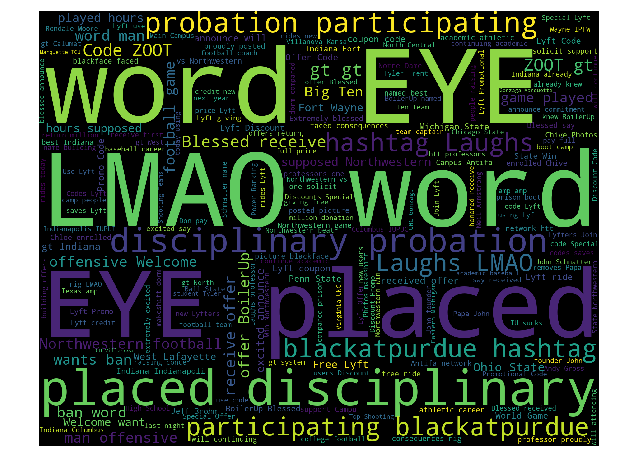

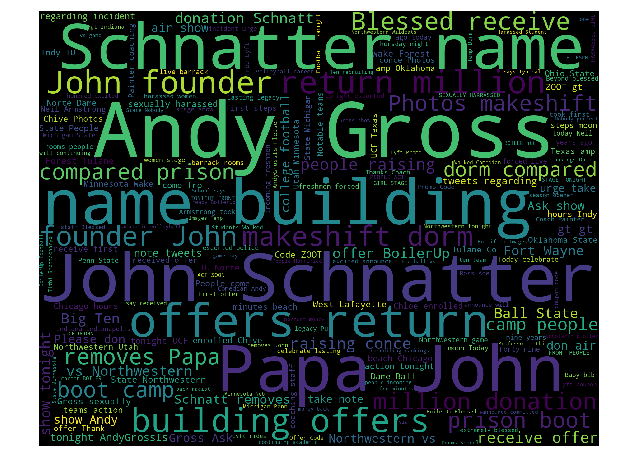

In [222]:
# join tweets to a single string

words = ' '.join(element.loc[(element['NameofUniv']== 'purdue'),'text'])
plotWordCloud(words)


words = ' '.join(element.loc[(element['NameofUniv']== 'purdue')&\
                             (element['TweetDate'] >='2018-07-15') &\
                             (element['TweetDate'] <='2018-08-30'),'text'])
plotWordCloud(words)


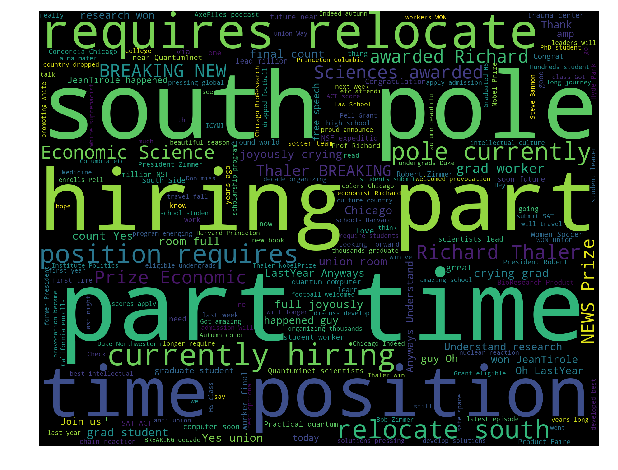

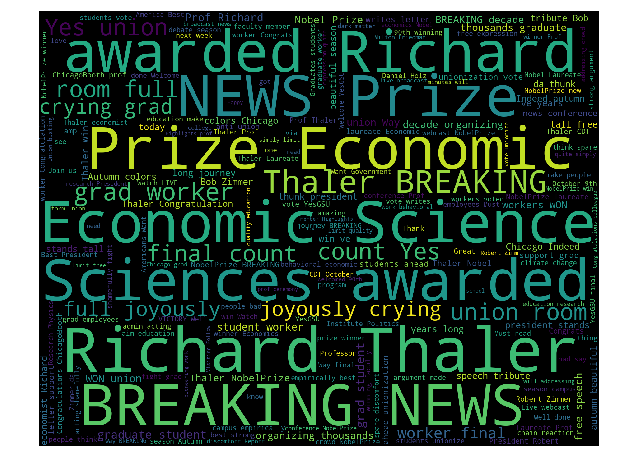

In [223]:
# join tweets to a single string
words = ' '.join(element.loc[(element['NameofUniv']== 'uchicago') ,'text'])
plotWordCloud(words)

# join tweets to a single string
words = ' '.join(element.loc[(element['NameofUniv']== 'uchicago')&\
                             (element['TweetDate'] >='2017-10-01') &\
                             (element['TweetDate'] <='2017-10-30'),'text'])

plotWordCloud(words)

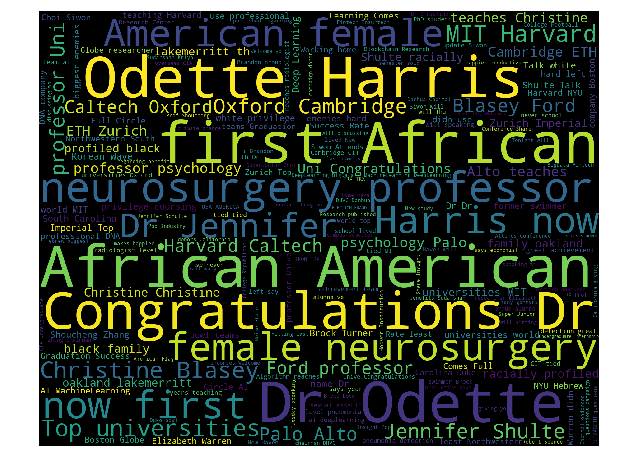

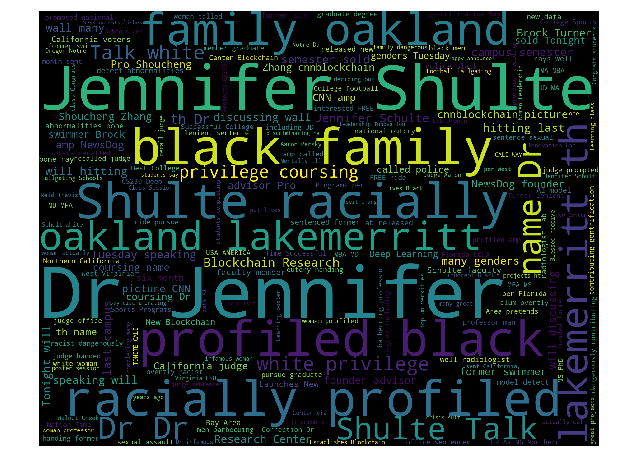

In [224]:
# join tweets to a single string
words = ' '.join(element.loc[element['NameofUniv']== 'stanford','text'])
plotWordCloud(words)

words = ' '.join(element.loc[(element['NameofUniv']== 'stanford')&\
                             (element['TweetDate'] >='2018-05-15') &\
                             (element['TweetDate'] <='2018-06-30'),'text'])

plotWordCloud(words)

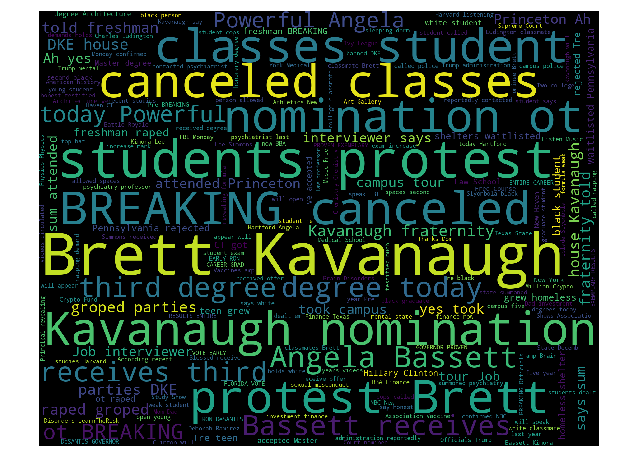

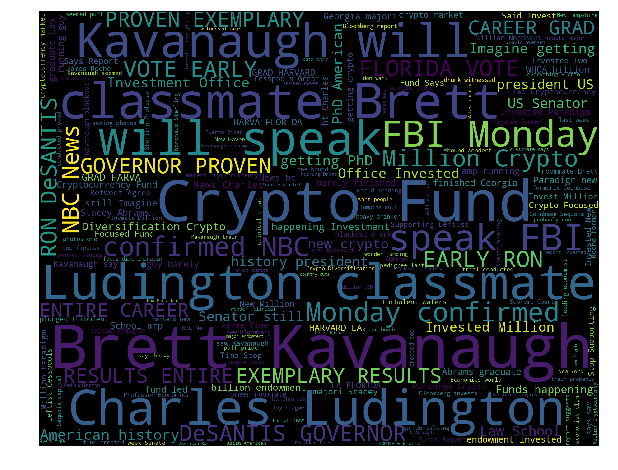

In [250]:
words = ' '.join(element.loc[element['NameofUniv']== 'yale','text'])
plotWordCloud(words)

words = ' '.join(element.loc[(element['NameofUniv']== 'yale')&\
                             (element['TweetDate'] >='2018-10-01') &\
                             (element['TweetDate'] <='2018-10-30'),'text'])

plotWordCloud(words)

In [226]:
element_dupDF = element.loc[(element['TweetCnt'] ==1)&(element['university_tweet'] ==1) ,['NameofUniv','text']]
element_dupDF.reset_index(inplace=True, drop=True)
element_dupDF.count()
#    no_urls_no_tags = "re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())
element_dupDF.head()

,NameofUniv,text
0,yale,So...someone not involved with the university whatsoever is bringing this lawsuit. *checks Yale diploma on the wall… https://t.co/1uG4lz...
1,stanford,"Me freshman year : ""I'm going to go to Stanford university once high school ends""\nMe sophmore year: ""I'm going to g… https://t.co/zncDo..."
2,stanford,@Stanford so is #bbqbecky an employee of Stanford university or not? On her deleted social media page it said emplo… https://t.co/rRF8zN...
3,yale,"Good. In line w this, Yale and other universities should also take better action to protect its students from sexua… https://t.co/wT8NyG..."
4,yale,wait since when is Yale a conservative university?


In [227]:
element_dupDF['text'] = element_dupDF['text'].apply(lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x))

In [228]:
element_dupDF.head()

,NameofUniv,text
0,yale,So someone not involved with the university whatsoever is bringing this lawsuit checks Yale diploma on the wall
1,stanford,Me freshman year I m going to go to Stanford university once high school ends Me sophmore year I m going to g
2,stanford,so is bbqbecky an employee of Stanford university or not On her deleted social media page it said emplo
3,yale,Good In line w this Yale and other universities should also take better action to protect its students from sexua
4,yale,wait since when is Yale a conservative university


In [229]:
def get_features(s):
    width = 3
    s = s.lower()
    s = re.sub(r'[^\w]+', '', s)
    return [s[i:i + width] for i in range(max(len(s) - width + 1, 1))]

### Find Duplicate tweets for Uchicago

In [230]:
data = element_dupDF.loc[element_dupDF['NameofUniv']=='uchicago','text'].to_dict()
objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
full_index = SimhashIndex(objs, k=10)

In [231]:
%%capture
dup_list = []
for j in range(0,len(objs)):
    dups = full_index.get_near_dups(objs[j][1]);
    dup_list.append([int(objs[j][0]),(len(dups)-1)])

           Record  Rcounts
0  Near-Duplicate       84
1          Unique      479


(array([0, 1]), <a list of 2 Text xticklabel objects>)

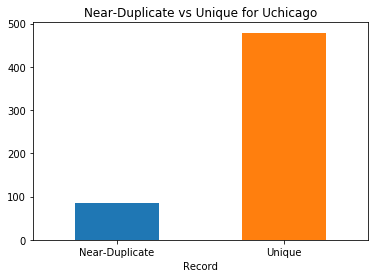

In [232]:
df_1 = pd.DataFrame(dup_list, columns = ["ind","num_of_dup"])
df_1.head()
num_unique= df_1[df_1['num_of_dup']==0].count().tolist()[1]
num_dup= df_1[df_1['num_of_dup']>0].count().tolist()[1]
list1 = [('Near-Duplicate',num_dup),('Unique',num_unique)]
labels = ['Record','Rcounts']
bar_data= pd.DataFrame.from_records(list1,columns=labels)
print(bar_data)
time_plot = bar_data.plot(kind='Bar',x='Record', y='Rcounts', legend= None, title="Near-Duplicate vs Unique for Uchicago")
plt.xticks(rotation='horizontal')

([<matplotlib.axis.XTick at 0x1ad5495278>,
 <a list of 19 Text xticklabel objects>)

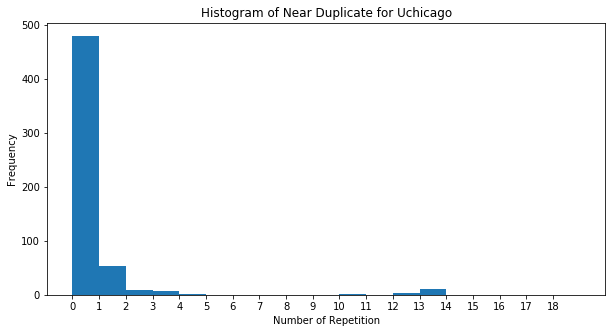

In [233]:
plt.figure(figsize=(10,5))
plt.title(r'Histogram of Near Duplicate for Uchicago')
plt.xlabel('Number of Repetition')
plt.ylabel('Frequency')
plt.hist(df_1["num_of_dup"],bins=range(0,20,1))
plt.xticks(range(0, 19))

### Find Duplicate tweets for Purdue 

In [234]:
data = element_dupDF.loc[element_dupDF['NameofUniv']=='purdue','text'].to_dict()
objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
full_index = SimhashIndex(objs, k=10)

In [235]:
%%capture
dup_list = []
for j in range(0,len(objs)):
    dups = full_index.get_near_dups(objs[j][1]);
    dup_list.append([int(objs[j][0]),(len(dups)-1)])

           Record  Rcounts
0  Near-Duplicate      895
1          Unique     1290


(array([0, 1]), <a list of 2 Text xticklabel objects>)

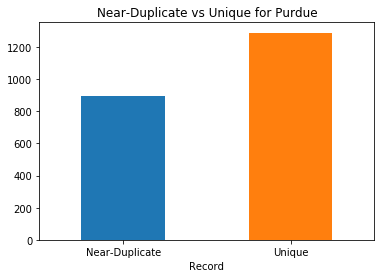

In [236]:
df_1 = pd.DataFrame(dup_list, columns = ["ind","num_of_dup"])
df_1.head()
num_unique= df_1[df_1['num_of_dup']==0].count().tolist()[1]
num_dup= df_1[df_1['num_of_dup']>0].count().tolist()[1]
list1 = [('Near-Duplicate',num_dup),('Unique',num_unique)]
labels = ['Record','Rcounts']
bar_data= pd.DataFrame.from_records(list1,columns=labels)
print(bar_data)
time_plot = bar_data.plot(kind='Bar',x='Record', y='Rcounts', legend= None, title="Near-Duplicate vs Unique for Purdue")
plt.xticks(rotation='horizontal')

([<matplotlib.axis.XTick at 0x1b20336208>,
 <a list of 19 Text xticklabel objects>)

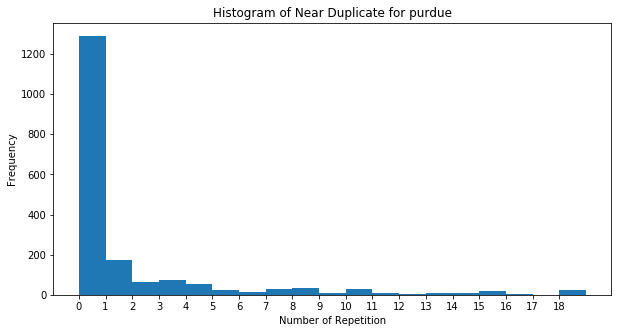

In [237]:
plt.figure(figsize=(10,5))
plt.title(r'Histogram of Near Duplicate for purdue')
plt.xlabel('Number of Repetition')
plt.ylabel('Frequency')
plt.hist(df_1["num_of_dup"],bins=range(0,20,1))
plt.xticks(range(0, 19))

### Find Duplicate tweets for stanford

In [238]:
data = element_dupDF.loc[element_dupDF['NameofUniv']=='stanford','text'].to_dict()
objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]

full_index = SimhashIndex(objs, k=10)

In [239]:
%%capture
dup_list = []
for j in range(0,len(objs)):
    dups = full_index.get_near_dups(objs[j][1]);
    dup_list.append([int(objs[j][0]),(len(dups)-1)])
    


           Record  Rcounts
0  Near-Duplicate     1792
1          Unique     3264


(array([0, 1]), <a list of 2 Text xticklabel objects>)

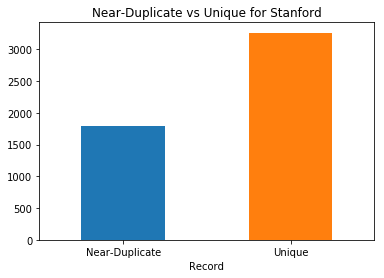

In [240]:
df_1 = pd.DataFrame(dup_list, columns = ["ind","num_of_dup"])
df_1.head()
num_unique= df_1[df_1['num_of_dup']==0].count().tolist()[1]
num_dup= df_1[df_1['num_of_dup']>0].count().tolist()[1]
list1 = [('Near-Duplicate',num_dup),('Unique',num_unique)]
labels = ['Record','Rcounts']
bar_data= pd.DataFrame.from_records(list1,columns=labels)
print(bar_data)
time_plot = bar_data.plot(kind='Bar',x='Record', y='Rcounts', legend= None, title="Near-Duplicate vs Unique for Stanford")
plt.xticks(rotation='horizontal')


([<matplotlib.axis.XTick at 0x1af5104a58>,
 <a list of 19 Text xticklabel objects>)

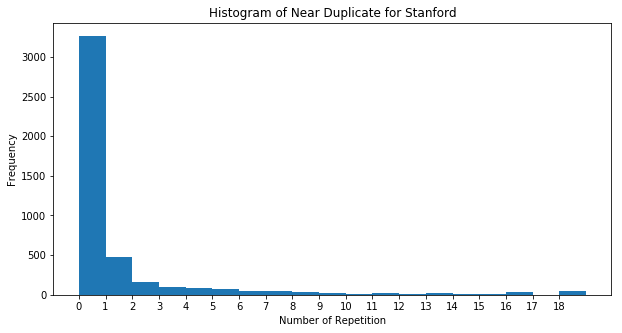

In [241]:
plt.figure(figsize=(10,5))
plt.title(r'Histogram of Near Duplicate for Stanford')
plt.xlabel('Number of Repetition')
plt.ylabel('Frequency')
plt.hist(df_1["num_of_dup"],bins=range(0,20,1))
plt.xticks(range(0, 19))    

### Find Duplicate tweets for yale

In [242]:
data = element_dupDF.loc[element_dupDF['NameofUniv']=='yale','text'].to_dict()
objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
full_index = SimhashIndex(objs, k=10)

In [243]:
%%capture
dup_list = []
for j in range(0,len(objs)):
    dups = full_index.get_near_dups(objs[j][1]);
    dup_list.append([int(objs[j][0]),(len(dups)-1)])

           Record  Rcounts
0  Near-Duplicate     1818
1          Unique     4049


(array([0, 1]), <a list of 2 Text xticklabel objects>)

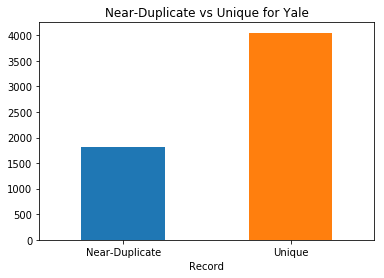

In [244]:
df_1 = pd.DataFrame(dup_list, columns = ["ind","num_of_dup"])
df_1.head()
num_unique= df_1[df_1['num_of_dup']==0].count().tolist()[1]
num_dup= df_1[df_1['num_of_dup']>0].count().tolist()[1]
list1 = [('Near-Duplicate',num_dup),('Unique',num_unique)]
labels = ['Record','Rcounts']
bar_data= pd.DataFrame.from_records(list1,columns=labels)
print(bar_data)
time_plot = bar_data.plot(kind='Bar',x='Record', y='Rcounts', legend= None, title="Near-Duplicate vs Unique for Yale")
plt.xticks(rotation='horizontal')

([<matplotlib.axis.XTick at 0x1aaad1a898>,
 <a list of 19 Text xticklabel objects>)

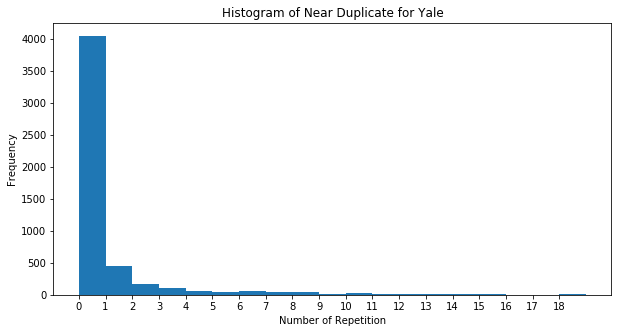

In [245]:
plt.figure(figsize=(10,5))
plt.title(r'Histogram of Near Duplicate for Yale')
plt.xlabel('Number of Repetition')
plt.ylabel('Frequency')
plt.hist(df_1["num_of_dup"],bins=range(0,20,1))
plt.xticks(range(0, 19))

### Find Duplicate for all University Tweets

In [246]:
data = element_dupDF.loc[element_dupDF['NameofUniv']=='yale','text'].to_dict()
objs = [(str(k), Simhash(get_features(v))) for k, v in data.items()]
full_index = SimhashIndex(objs, k=10)

In [247]:
%%capture
dup_list = []
for j in range(0,len(objs)):
    dups = full_index.get_near_dups(objs[j][1]);
    dup_list.append([int(objs[j][0]),(len(dups)-1)])

           Record  Rcounts
0  Near-Duplicate     1818
1          Unique     4049


(array([0, 1]), <a list of 2 Text xticklabel objects>)

<Figure size 1296x576 with 0 Axes>

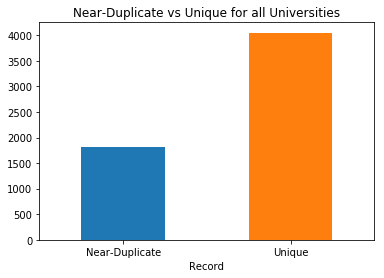

In [248]:
df_1 = pd.DataFrame(dup_list, columns = ["ind","num_of_dup"])
df_1.head()
num_unique= df_1[df_1['num_of_dup']==0].count().tolist()[1]
num_dup= df_1[df_1['num_of_dup']>0].count().tolist()[1]
list1 = [('Near-Duplicate',num_dup),('Unique',num_unique)]
labels = ['Record','Rcounts']

bar_data= pd.DataFrame.from_records(list1,columns=labels)
print(bar_data)
plt.figure(figsize=(18,8))
time_plot = bar_data.plot(kind='Bar',x='Record', y='Rcounts', legend= None, title="Near-Duplicate vs Unique for all Universities")
plt.xticks(rotation='horizontal')

([<matplotlib.axis.XTick at 0x1b203d92b0>,
 <a list of 19 Text xticklabel objects>)

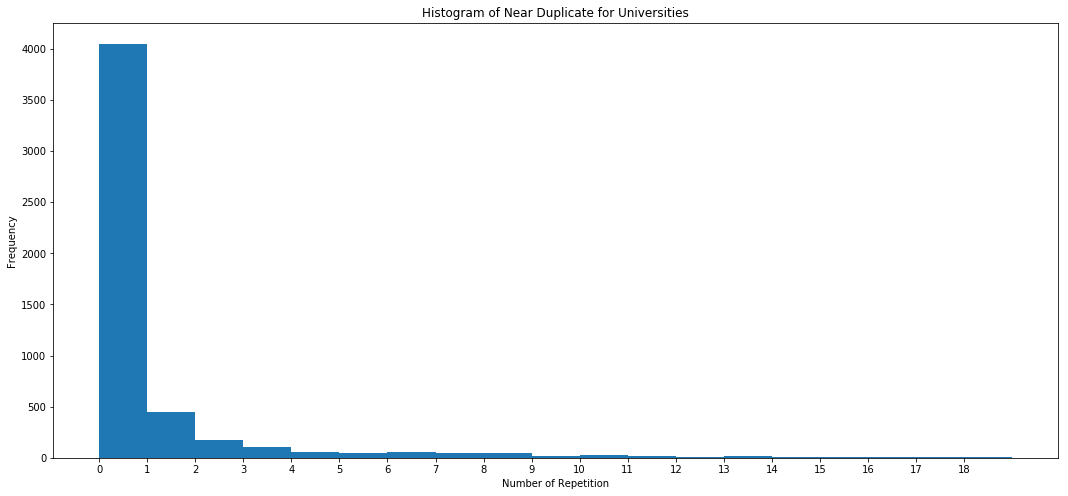

In [249]:
plt.figure(figsize=(18,8))
plt.title(r'Histogram of Near Duplicate for Universities')
plt.xlabel('Number of Repetition')
plt.ylabel('Frequency')
plt.hist(df_1["num_of_dup"],bins=range(0,20,1))
plt.xticks(range(0, 19))